## Task 2

Setup a NN to regress aco_angle_1 - this will give us some ideas about how we need to setup the NN in order for it to make use of the low-level information and then we can use a similar architecture for our final NN setup. After reading around online a bit one possible reason that the NN is not working very well is because the CP observables depend on what rest frame you determine them in and possibly the NN is not well setup to handle Lorentz boosts into different frames. I found a paper which suggest how to setup the first layers of a NN in order to perform such Lorentz boosts (https://arxiv.org/pdf/1812.09722.pdf) - this might be a good place to start, but of course if you have other ideas you are free to follow themSet up a Neural Network to reconstruct the aco_angle_1 from basic variables. 

In [ ]:
!pip install --user uproot
!pip install --user lbn
!pip install --user tensorflow
import sys
sys.path.append("/eos/home-m/acraplet/.local/lib/python2.7/site-packages")

In [ ]:
import uproot 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt


from lbn import LBN, LBNLayer
import tensorflow as tf
import keras


In [3]:
# loading the tree
tree = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]

In [65]:
# define what variables are to be read into the dataframe

momenta_features = [ "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", #leading charged pi 4-momentum
              "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", #subleading charged pi 4-momentum
              "pi0_E_1","pi0_px_1","pi0_py_1","pi0_pz_1", #leading neutral pi 4-momentum
              "pi0_E_2","pi0_px_2","pi0_py_2","pi0_pz_2"] #subleading neutral pi 4-momentum

other_features = [ "ip_x_1", "ip_y_1", "ip_z_1",        #leading impact parameter
                   "ip_x_2", "ip_y_2", "ip_z_2",        #subleading impact parameter
                   "y_1_1", "y_1_2"]    # ratios of energies

target = [    "aco_angle_1"]  #acoplanarity angle
    
selectors = [ "tau_decay_mode_1","tau_decay_mode_2",
             "mva_dm_1","mva_dm_2","rand","wt_cp_ps","wt_cp_sm",
            ]

variables4=(momenta_features+other_features+target+selectors) #copying Kinglsey's way cause it is very clean

df4 = tree.pandas.df(variables4)

df4 = df4[
      (df4["tau_decay_mode_1"] == 1) 
    & (df4["tau_decay_mode_2"] == 1) 
    & (df4["mva_dm_1"] == 1) 
    & (df4["mva_dm_2"] == 1)
]



df_ps = df4[
      (df4["rand"]<df4["wt_cp_ps"]/2)     #a data frame only including the pseudoscalars
]

df_sm = df4[
      (df4["rand"]<df4["wt_cp_sm"]/2)     #data frame only including the scalars
]


In [66]:
df4.head()

,pi_E_1,pi_px_1,pi_py_1,pi_pz_1,pi_E_2,pi_px_2,pi_py_2,pi_pz_2,pi0_E_1,pi0_px_1,...,y_1_1,y_1_2,aco_angle_1,tau_decay_mode_1,tau_decay_mode_2,mva_dm_1,mva_dm_2,rand,wt_cp_ps,wt_cp_sm
entry,,,,,,,,,,,,,,,,,,,,,
4,26.184192,5.249920,-12.394966,-22.458754,52.305565,-10.016787,40.401790,-31.673523,95.932667,20.387663,...,0.571162,-0.773942,5.927902,1,1,1,1,0.424206,0.851171,0.729696
15,3.912128,3.186334,0.086207,-2.263873,32.211659,7.872188,29.660602,9.790244,64.282235,52.942869,...,0.885265,-0.339467,5.015406,1,1,1,1,0.175598,0.863414,1.909411
26,20.389432,12.846308,15.714182,1.935544,5.313678,-4.517069,-2.251007,1.656731,35.041365,21.823335,...,0.264328,0.760691,3.019532,1,1,1,1,0.335537,0.345069,1.931279
39,4.532329,-1.060811,2.501133,-3.625128,11.348225,-2.284085,-6.326895,-9.138714,102.977036,-25.022726,...,0.915685,0.772376,2.650678,1,1,1,1,0.585149,0.416681,0.579716
55,77.929050,28.100279,42.522791,58.950012,72.891011,8.689332,15.745896,70.637400,68.260095,25.125369,...,-0.066140,0.534360,3.057700,1,1,1,1,0.162284,1.231858,0.971241


## Try and do everything at once

In [163]:
#The different 4 vectors, (E,px,py,pz)
pi_1=np.array([df4["pi_E_1"],df4["pi_px_1"],df4["pi_py_1"],df4["pi_pz_1"]])
pi_2=np.array([df4["pi_E_2"],df4["pi_px_2"],df4["pi_py_2"],df4["pi_pz_2"]])

pi0_1=np.array([df4["pi0_E_1"],df4["pi0_px_1"],df4["pi0_py_1"],df4["pi0_pz_1"]])
pi0_2=np.array([df4["pi0_E_2"],df4["pi0_px_2"],df4["pi0_py_2"],df4["pi0_pz_2"]])


# Create x and y tensors
#x = tf.convert_to_tensor(np.array(df4[momenta_features],dtype=np.float32), dtype=np.float32)
#x = tf.constant(np.array(df4[momenta_features],np.float32),dtype="float32")

# Reshape for LBN
#x = tf.reshape(x, (x.shape[0], 4, 4)) #have I reshaped anything really ??
#print(x)

# Normalise input:
#x = (x - tf.math.reduce_mean(x,axis = 0))/tf.math.reduce_std(x, axis=0)

#y = tf.convert_to_tensor(np.array(df4[["aco_angle_1"]],dtype=np.float32), dtype=np.float32) #this is the target
#y = tf.constant(np.array(df4[["aco_angle_1"]],dtype=np.float32),dtype="float32")

#print(y,x)


1.14.0
Tensor("Reshape_41:0", shape=(145487, 4, 4), dtype=float32)
Tensor("Const_108:0", shape=(145487, 1), dtype=float32) Tensor("Reshape_41:0", shape=(145487, 4, 4), dtype=float32)


In [170]:
#Now we will try and use lbn to get aco_angle_1 from the 'raw data'

# start a sequential model
model = tf.keras.models.Sequential()

# add the LBN layer
input_shape = (4, 4) #what input shape do we want ?

#we have 4 particles,
output = ["E", "px","py","pz","pt","pair_dy"]  #all the output we want  


#define NN model and compile
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten( input_shape=(4,4)),
    #LBNLayer((4, 4), 11, boost_mode=LBN.PAIRS, features=LBN_output_features),
    tf.keras.layers.BatchNormalization(),   #what does this do ?
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['mse'])

model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_46 (Dense)             (None, 300)               5100      
_________________________________________________________________
dense_47 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 301       
Total params: 95,765
Trainable params: 95,733
Non-trainable params: 32
_________________________________________________________________


In [171]:
#Next run it
# compile the model (we have to pass a loss or it won't compile)
loss_fn = tf.keras.losses.MeanSquaredError() #try with this function but could do with loss="categorical_crossentropy" instead
model.compile(loss=loss_fn,optimizer='adam', metrics=['mse'])


x=np.array(df4[momenta_features],dtype=np.float32)
x=np.reshape(x,(len(x),4,4))    #could there be an issue with how x and y are defined as in the reshaping of x?
y=np.array(df4[["aco_angle_1"]],dtype=np.float32)

#train model
history = model.fit(x, y, validation_split=0.3, epochs=50)

Train on 101840 samples, validate on 43647 samples
Epoch 1/50
101840/101840 [==============================] - 24s 237us/sample - loss: 3.4229 - mean_squared_error: 3.4229 - val_loss: 3.3396 - val_mean_squared_error: 3.3396
Epoch 2/50
101840/101840 [==============================] - 24s 231us/sample - loss: 3.3499 - mean_squared_error: 3.3499 - val_loss: 3.3243 - val_mean_squared_error: 3.3243
Epoch 3/50
101840/101840 [==============================] - 23s 226us/sample - loss: 3.3311 - mean_squared_error: 3.3311 - val_loss: 3.3301 - val_mean_squared_error: 3.3301
Epoch 4/50
101840/101840 [==============================] - 22s 215us/sample - loss: 3.3199 - mean_squared_error: 3.3199 - val_loss: 3.3222 - val_mean_squared_error: 3.3222
Epoch 5/50
101840/101840 [==============================] - 19s 188us/sample - loss: 3.3148 - mean_squared_error: 3.3148 - val_loss: 3.3082 - val_mean_squared_error: 3.3082
Epoch 6/50
101840/101840 [==============================] - 20s 194us/sample - loss:

KeyboardInterrupt: 

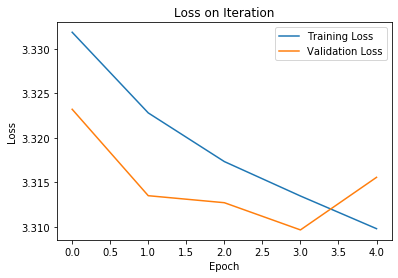

In [169]:
#plot traning
plt.figure()
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss on Iteration")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#mean square error is how bad it is... pi is I'll guess the middle each time

##  Try and let the program do half and us the other half

In [172]:
!pip install --user pylorentz

from pylorentz import Momentum4
from pylorentz import Vector4
from pylorentz import Position4

In [173]:
#Some geometrical functions

def cross_product(vector3_1,vector3_2):
    if len(vector3_1)!=3 or len(vector3_1)!=3:
        print('These are not 3D arrays !')
    x_perp_vector=vector3_1[1]*vector3_2[2]-vector3_1[2]*vector3_2[1]
    y_perp_vector=vector3_1[2]*vector3_2[0]-vector3_1[0]*vector3_2[2]
    z_perp_vector=vector3_1[0]*vector3_2[1]-vector3_1[1]*vector3_2[0]
    return np.array([x_perp_vector,y_perp_vector,z_perp_vector])

def dot_product(vector1,vector2):
    if len(vector1)!=len(vector2):
        raise Arrays_of_different_size
    prod=0
    for i in range(len(vector1)):
        prod=prod+vector1[i]*vector2[i]
    return prod


def norm(vector):
    if len(vector)!=3:
        print('This is only for a 3d vector')
    return np.sqrt(vector[0]**2+vector[1]**2+vector[2]**2)

In [460]:
#Charged and neutral pion momenta
pi_1_4Mom=Momentum4(df4["pi_E_1"],df4["pi_px_1"],df4["pi_py_1"],df4["pi_pz_1"])
pi_2_4Mom=Momentum4(df4["pi_E_2"],df4["pi_px_2"],df4["pi_py_2"],df4["pi_pz_2"])

#Same for the pi0
pi0_1_4Mom=Momentum4(df4["pi0_E_1"],df4["pi0_px_1"],df4["pi0_py_1"],df4["pi0_pz_1"])
pi0_2_4Mom=Momentum4(df4["pi0_E_2"],df4["pi0_px_2"],df4["pi0_py_2"],df4["pi0_pz_2"])

#This is the COM frame of the two charged pions w.r.t. which we'll boost
ref_COM_4Mom=Momentum4(pi_1_4Mom+pi_2_4Mom)

energies=[df4["pi_E_1"],df4["pi_E_2"],df4["pi0_E_1"],df4["pi0_E_2"]]


#Lorentz boost everything in the ZMF of the two charged pions
pi0_1_4Mom_star=pi0_1_4Mom.boost_particle(-ref_COM_4Mom)
pi0_2_4Mom_star=pi0_2_4Mom.boost_particle(-ref_COM_4Mom)

#Lorentz boost everything in the ZMF of the two neutral pions
pi_1_4Mom_star=pi_1_4Mom.boost_particle(-ref_COM_4Mom)
pi_2_4Mom_star=pi_2_4Mom.boost_particle(-ref_COM_4Mom)


#calculating the perpependicular component
pi0_1_3Mom_star_perp=cross_product(pi0_1_4Mom_star[1:],pi_1_4Mom_star[1:])
pi0_2_3Mom_star_perp=cross_product(pi0_2_4Mom_star[1:],pi_2_4Mom_star[1:])

#Now normalise:
pi0_1_3Mom_star_perp=pi0_1_3Mom_star_perp/norm(pi0_1_3Mom_star_perp)
pi0_2_3Mom_star_perp=pi0_2_3Mom_star_perp/norm(pi0_2_3Mom_star_perp)

pi0_1_4Mom_star_perp=[pi0_1_4Mom_star[0],*pi0_1_3Mom_star_perp]
pi0_2_4Mom_star_perp=[pi0_1_4Mom_star[0],*pi0_2_3Mom_star_perp]

#Calculating phi_star
phi_CP=np.arccos(dot_product(pi0_1_3Mom_star_perp,pi0_2_3Mom_star_perp))

#The energy ratios
y_T = np.array(df4['y_1_1']*df4['y_1_2'])

#The O variable
cross=np.array(np.cross(pi0_1_3Mom_star_perp.transpose(),pi0_2_3Mom_star_perp.transpose()).transpose())
bigO=dot_product(pi_2_4Mom_star[1:],cross)



#perform the shift w.r.t. O* sign
#phi_CP=np.where(bigO>=0, 2*np.pi-phi_CP, phi_CP)#, phi_CP)


#additionnal shift that needs to be done do see differences between odd and even scenarios, with y=Energy ratios
#phi_CP=np.where(y_T>=0, np.where(phi_CP<np.pi, phi_CP+np.pi, phi_CP-np.pi), phi_CP)

#Here we have the right datasets after the boosting, let's try and get a NN to output aco_angle_1 from there

In [490]:
#data to be used in training

y=np.array(df4["aco_angle_1"],dtype="float32")
#y=np.reshape(y,(len(y[0]),len(y)))

#x=np.array([*pi0_2_4Mom_star_perp, *pi0_1_4Mom_star_perp, np.sign(y_T),*pi_2_4Mom_star[1:]],dtype="float32").transpose()
x=np.array([*pi0_2_4Mom_star_perp, *pi0_1_4Mom_star_perp, *pi_2_4Mom_star,*pi_1_4Mom_star],dtype="float32").transpose()
#x=np.reshape(x,(len(x),3,2)


In [491]:
#Now we will try and use lbn to get aco_angle_1 from the 'raw data'

# start a sequential model
model = tf.keras.models.Sequential()

#we have 4 particles,
#output = ["E", "px","py","pz","pt","pair_dy"]  #all the output we want  


#define NN model and compile, try with less layers with less nodes (all other inout features bring noise)
model = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(input_shape=(1,)),
    #tf.keras.layers.BatchNormalization(),   #what does this do : normlise all features, have 1std and mean 0?   
    tf.keras.layers.Dense(10, activation='relu',input_shape=(len(x[0]),)), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    #tf.keras.layers.Dense(8, activation='relu'), 
    #tf.keras.layers.Dense(30, activation='relu'),
    #tf.keras.layers.Dense(300, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer='Adam',
              loss=loss_fn,
              metrics=['mae'])


In [492]:
#train model
history = model.fit(x, y, validation_split=0.3, epochs=20)

Train on 101840 samples, validate on 43647 samples
Epoch 1/20
101840/101840 [==============================] - 14s 142us/sample - loss: 4.0601 - mean_absolute_error: 1.6831 - val_loss: 3.3457 - val_mean_absolute_error: 1.5804
Epoch 2/20
101840/101840 [==============================] - 10s 100us/sample - loss: 3.3259 - mean_absolute_error: 1.5774 - val_loss: 3.3050 - val_mean_absolute_error: 1.5733
Epoch 3/20
101840/101840 [==============================] - 10s 102us/sample - loss: 3.3100 - mean_absolute_error: 1.5751 - val_loss: 3.3115 - val_mean_absolute_error: 1.5744
Epoch 4/20
101840/101840 [==============================] - 9s 88us/sample - loss: 3.3082 - mean_absolute_error: 1.5746 - val_loss: 3.3020 - val_mean_absolute_error: 1.5729
Epoch 5/20
101840/101840 [==============================] - 10s 97us/sample - loss: 3.3065 - mean_absolute_error: 1.5743 - val_loss: 3.2989 - val_mean_absolute_error: 1.5723
Epoch 6/20
101840/101840 [==============================] - 9s 91us/sample - 

In [465]:
#each time giving the loss after 10 epochs

#tried running with phi_CP(before shift), bi0 and y_T, got 3.36 - bad
#tried running with phi_CP(after shift) - good
#tried running with phi_CP(after shift), b0 - bad
#tried running with phi_CP(after shift), phi_CP(after shift) - bad
#tried running with phi_CP(after shift), phi_CP(after shift) - with y is 2d - good
#tried running with phi_CP(after shift), bO -  with y is 2d - medium:1.05
#tried running with phi_CP(after shift b0, before shift y_T), y_T -  with y is 2d - overfitting
#tried running with phi_CP(after shift b0, before shift y_T), sign(y_T) -  bad
#tried running with phi_CP(after shift b0, before shift y_T), sign(y_T) - 3 nodes, 3 nodes -  bad
#tried running with phi_CP(after shift b0, before shift y_T), sign(y_T) - 3 nodes -  bad

#tried running with phi_CP(after shift b0.T, before shift y_T), sign(y_T) - 8 nodes -  great:0.2403   
#tried running with phi_CP(after shift b0.T, before shift y_T), y_T - 8 nodes -  good:0.6884 #could carry on longer
#tried running with phi_CP(after shift b0.T, before shift y_T), y_T - 15 nodes -  good:0.6542 #could carry on longer
#tried running with phi_CP(after shift b0.T, before shift y_T), y_T - 8 nodes and 8 nodes (relu)-  great:0.0611
#tried running with phi_CP(after shift b0.T, before shift y_T), y_T - 8 nodes and 8 nodes and 8 nodes -  good:0.0928
#tried running with phi_CP(after shift b0.T, before shift y_T), y_T - 8 nodes and 8 nodes (sigmoid)-  kinda bad:0.7547

#tried running with phi_CP(before any shift), y_T,bi0 - 8 nodes and 8 nodes (relu)-  impressive:0.1923 #could carry on
#tried running with phi_CP(before any shift), y_T,bi0 - 10 nodes and 10 nodes (relu)-  better:0.1327
#tried running with phi_CP(before any shift), y_T,bi0 - 15 nodes and 15 nodes (relu)-  worse:0.2187 #noise starts to creep in I think

#tried running with*pi0_1_3Mom_star_perp,*pi0_2_3Mom_star_perp - 10 nodes and 10 nodes (relu)- y= phi_CP - great:0.0038
#tried running with*pi0_1_3Mom_star_perp,*pi0_2_3Mom_star_perp,y_T,bigO - 10 nodes and 10 nodes (relu)- y= angle - good:0.7817
#tried running with*pi0_1_3Mom_star_perp,*pi0_2_3Mom_star_perp,np.sign(y_T),np.sign(bigO) - 10 nodes and 10 nodes (relu)- y= angle - great:0.0405
#tried running with*pi0_1_4Mom_star_perp,*pi0_2_4Mom_star_perp,np.sign(y_T),np.sign(bigO) - 10 nodes and 10 nodes (relu)- y= angle - still great:0.0631
#tried running with*pi0_1_4Mom_star_perp,*pi0_2_4Mom_star_perp,np.sign(y_T),*cross - 10 nodes and 10 nodes (relu)- y= angle - bad, because not included pi_2_4Mom_star
#tried running with*pi0_2_4Mom_star_perp, *pi0_1_4Mom_star_perp, np.sign(y_T), *cross,*pi_2_4Mom_star[1:] - (10,10) - y=angle - ok: 1.1545

#from now on, 20

#tried running with*pi0_2_4Mom_star_perp, *pi0_1_4Mom_star_perp, np.sign(y_T),*pi_2_4Mom_star[1:] - (10,10) - y=angle - not good:2.1157

# this is 'as low level' as we can go with bigO, try now to go low level on y_T

#tried running with*pi0_2_4Mom_star_perp, *pi0_1_4Mom_star_perp, *energies, bigO - (10,10) - y=angle - quite good:1.3131 
#tried running with*pi0_2_3Mom_star_perp, *pi0_1_3Mom_star_perp, *energies, bigO - (10,10) - y=angle - better : 1.1867
#tried running with*pi0_2_4Mom_star_perp, *pi0_1_4Mom_star_perp, y_T, bigO -(10,10) - y=angle - obv better : 0.3337

#now try both modified:
#tried running with*pi0_2_4Mom_star_perp, *pi0_1_4Mom_star_perp, *energies,*pi_2_4Mom_star[1:] - (10,10) - y=angle - bad: 3.3020 
#tried running with*pi0_2_4Mom_star_perp, *pi0_1_4Mom_star_perp, *pi_2_4Mom_star[1:],*pi_1_4Mom_star[1:] - (10,10) - y=angle - actually better: 3.1315
#tried running with*pi0_2_4Mom_star_perp, *pi0_1_4Mom_star_perp, *pi_2_4Mom_star[1:],*pi_1_4Mom_star[1:] - (10,10,10) - y=angle - still better:3.0340
#which is really weird because we do not have the energies of the pi


#tried running with*pi0_2_4Mom_star_perp, *pi0_1_4Mom_star_perp, *pi_2_4Mom_star,*pi_1_4Mom_star - (10,10,10) - y=angle - not much better:3.0302 


In [464]:
#Could we load a specific pre-trained layer being taught about cross products on simpler data sets
#https://www.tensorflow.org/api_docs/python/tf/keras/losses/cosine_similarity

In [ ]:
#plot traning
plt.figure()
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss on Iteration")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

(array([10224., 21670., 19977., 15130., 12006., 10708., 10987., 12630.,
        16268., 15887.]),
 array([-0.96166522, -0.76783311, -0.57400101, -0.38016891, -0.18633681,
         0.00749529,  0.20132739,  0.39515949,  0.58899159,  0.78282369,
         0.9766558 ]),
 <a list of 10 Patch objects>)

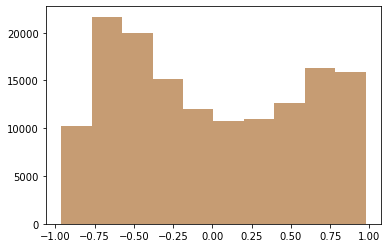

In [196]:
#It doesn't work very well, is it missing the value of y_T ?

y_1=(-df4["pi_E_1"]+df4["pi0_E_1"])/(df4["pi_E_1"]+df4["pi0_E_1"]) #so yeah retrives it from the energy is possible
y_2=(-df4["pi_E_2"]+df4["pi0_E_2"])/(df4["pi_E_2"]+df4["pi0_E_2"])

plt.hist(y_2,alpha=0.5)
plt.hist(df4["y_1_2"],alpha=0.5)